In [80]:
import pandas as pd
import numpy as np

df = pd.read_csv("player_season_stats_23-24_relevant.csv")

min90_col = "90s Playing Time"

core_features = [
    # Attacking & Shot Creation
    'npxG Per 90 Minutes',
    'G-PK Per 90 Minutes',
    'xAG Per 90 Minutes',
    'xG+xAG Per 90 Minutes',
    'Sh/90 Standard',
    'SoT% Standard',
    'G/Sh Standard',

    # Progressive Passing
    'PrgP',
    'KP',
    'PPA',
    'CrsPA',

    # Carries & Dribbling
    'PrgC Carries',
    'CPA Carries',
    'Succ Take-Ons',
    'Succ% Take-Ons',

    # Receiving
    'PrgR Receiving',

    # Defensive Actions
    'TklW Tackles',
    'Int',

    # Aerial & Duels
    'Won Aerial Duels',
    'Won% Aerial Duels',

    # Discipline & Fouls
    'Fls Performance',
    'Fld Performance',

    # Touches
    'Att 3rd Touches',
    'Mid 3rd Touches',
    'Def 3rd Touches'
]

# sanity check: all features exist in df
missing = [c for c in core_features if c not in df.columns]
print("Missing in df:", missing)


Missing in df: []


In [81]:
# per-90 stats (already per 90 in FBref)
per90_cols = [
    'npxG Per 90 Minutes',
    'G-PK Per 90 Minutes',
    'xAG Per 90 Minutes',
    'xG+xAG Per 90 Minutes',
    'Sh/90 Standard',
]

# percentage / rate stats (we'll keep them as weighted averages)
pct_cols = [
    'SoT% Standard',
    'G/Sh Standard',
    'Succ% Take-Ons',
    'Won% Aerial Duels',
]

# everything else are counts
count_cols = [c for c in core_features if c not in per90_cols + pct_cols]
count_cols


['PrgP',
 'KP',
 'PPA',
 'CrsPA',
 'PrgC Carries',
 'CPA Carries',
 'Succ Take-Ons',
 'PrgR Receiving',
 'TklW Tackles',
 'Int',
 'Won Aerial Duels',
 'Fls Performance',
 'Fld Performance',
 'Att 3rd Touches',
 'Mid 3rd Touches',
 'Def 3rd Touches']

In the cell below: 

✔ Convert per-90 stats to raw totals

✔ Convert percentages to weighted sums

✔ Prepare the dataset for merging multiple rows per player

✔ Ensure later per-90 recalculation will be accurate

In [82]:
df2 = df.copy()

# 1) per-90 → raw totals
for col in per90_cols:
    df2[col + "_raw"] = df2[col] * df2[min90_col]

# 2) % stats → weighted sums (value * 90s)
for col in pct_cols:
    df2[col + "_w"] = df2[col] * df2[min90_col]


In [83]:
# Initialize aggregation dictionary
agg_dict = {
    "league": "first", ## no need for summing, we keep the first occurrence
    "season": "first",
    "team": "first",
    "nation": "first",
    "pos": "first",
    "age": "mean",
    min90_col: "sum",
}

# sum all count features
for col in count_cols:
    agg_dict[col] = "sum"

# sum raw totals for per-90 stats
for col in per90_cols:
    agg_dict[col + "_raw"] = "sum"

# sum weighted % stats
for col in pct_cols:
    agg_dict[col + "_w"] = "sum"

merged = df2.groupby("player", as_index=False).agg(agg_dict)
merged.head()


,player,league,season,team,nation,pos,age,90s Playing Time,PrgP,KP,...,Def 3rd Touches,npxG Per 90 Minutes_raw,G-PK Per 90 Minutes_raw,xAG Per 90 Minutes_raw,xG+xAG Per 90 Minutes_raw,Sh/90 Standard_raw,SoT% Standard_w,G/Sh Standard_w,Succ% Take-Ons_w,Won% Aerial Duels_w
0,Aaron Cresswell,ENG-Premier League,2324,West Ham,ENG,"DF,FW",33.0,4.8,26,5,...,125,0.000,0.0,0.432,0.432,0.000,0.00,0.0,0.00,320.16
1,Aaron Hickey,ENG-Premier League,2324,Brentford,SCO,DF,21.0,7.9,21,1,...,132,0.237,0.0,0.079,0.316,6.952,112.97,0.0,282.03,79.00
2,Aaron Malouda,FRA-Ligue 1,2324,Lille,FRA,FW,17.0,0.0,0,0,...,0,0.000,0.0,0.000,0.000,0.000,0.00,0.0,0.00,0.00
3,Aaron Ramsdale,ENG-Premier League,2324,Arsenal,ENG,GK,25.0,6.0,2,0,...,186,0.000,0.0,0.000,0.000,0.000,0.00,0.0,0.00,0.00
4,Aaron Ramsey,ENG-Premier League,2324,Burnley,ENG,"MF,FW",20.0,5.9,8,1,...,63,0.354,0.0,0.413,0.767,6.018,196.47,0.0,177.00,261.96


The cell below: rebuilds all per-90 and % stats at the player level, after merging.

In [84]:
den = merged[min90_col].replace(0, np.nan)  # total 90s per player

# 1) attacking / shot creation (per 90)
merged['npxG_per90']      = merged['npxG Per 90 Minutes_raw']   / den
merged['GminusPK_per90']  = merged['G-PK Per 90 Minutes_raw']   / den
merged['xAG_per90']       = merged['xAG Per 90 Minutes_raw']    / den
merged['xG_xAG_per90']    = merged['xG+xAG Per 90 Minutes_raw'] / den
merged['Sh_per90']        = merged['Sh/90 Standard_raw']        / den

# 2) progressive passing (counts → per 90)
merged['PrgP_per90']      = merged['PrgP']          / den
merged['KP_per90']        = merged['KP']           / den
merged['PPA_per90']       = merged['PPA']          / den
merged['CrsPA_per90']     = merged['CrsPA']        / den

# 3) carries & dribbling
merged['PrgC_carries_per90'] = merged['PrgC Carries']  / den
merged['CPA_per90']          = merged['CPA Carries']   / den
merged['Succ_takeons_per90'] = merged['Succ Take-Ons'] / den

# 4) receiving
merged['PrgR_per90']      = merged['PrgR Receiving'] / den

# 5) defensive actions
merged['TklW_per90']      = merged['TklW Tackles'] / den
merged['Int_per90']       = merged['Int']          / den

# 6) aerial & duels
merged['WonAerials_per90'] = merged['Won Aerial Duels'] / den

# 7) discipline & fouls
merged['Fls_per90']       = merged['Fls Performance'] / den
merged['Fld_per90']       = merged['Fld Performance'] / den

# 8) touches
merged['Att3rdT_per90']   = merged['Att 3rd Touches'] / den
merged['Mid3rdT_per90']   = merged['Mid 3rd Touches'] / den
merged['Def3rdT_per90']   = merged['Def 3rd Touches'] / den

# 9) recompute % features as weighted averages
merged['SoT%']        = merged['SoT% Standard_w']    / den
merged['GperSh']      = merged['G/Sh Standard_w']    / den
merged['Succ%_TO']    = merged['Succ% Take-Ons_w']   / den
merged['Won%_Aerial'] = merged['Won% Aerial Duels_w']/ den


This list contains all the per-90, percentage, and weighted features you computed earlier — extracted from your cleaned dataset.

These 26 features are the input vectors that the clustering algorithm will use to compare player similarity.

In [85]:
feature_cols = [
    # Attacking & shot creation
    'npxG_per90',
    'GminusPK_per90',
    'xAG_per90',
    'xG_xAG_per90',
    'Sh_per90',
    'SoT%',
    'GperSh',

    # Progressive passing
    'PrgP_per90',
    'KP_per90',
    'PPA_per90',
    'CrsPA_per90',

    # Carries & dribbling
    'PrgC_carries_per90',
    'CPA_per90',
    'Succ_takeons_per90',
    'Succ%_TO',

    # Receiving
    'PrgR_per90',

    # Defensive actions
    'TklW_per90',
    'Int_per90',

    # Aerial & duels
    'WonAerials_per90',
    'Won%_Aerial',

    # Discipline & fouls
    'Fls_per90',
    'Fld_per90',

    # Touches
    'Att3rdT_per90',
    'Mid3rdT_per90',
    'Def3rdT_per90'
]

player_features = merged[['player', 'team', 'nation', 'pos', 'age', min90_col] + feature_cols]

# Drop players with missing values in the features (if any)
player_features = player_features.dropna(subset=feature_cols)

player_features.head()


,player,team,nation,pos,age,90s Playing Time,npxG_per90,GminusPK_per90,xAG_per90,xG_xAG_per90,...,PrgR_per90,TklW_per90,Int_per90,WonAerials_per90,Won%_Aerial,Fls_per90,Fld_per90,Att3rdT_per90,Mid3rdT_per90,Def3rdT_per90
0,Aaron Cresswell,West Ham,ENG,"DF,FW",33.0,4.8,0.00,0.00,0.09,0.09,...,1.250000,0.416667,0.625000,1.250000,66.7,0.416667,0.625000,12.708333,29.375000,26.041667
1,Aaron Hickey,Brentford,SCO,DF,21.0,7.9,0.03,0.00,0.01,0.04,...,1.645570,1.139241,0.379747,0.126582,10.0,1.265823,2.025316,9.620253,19.620253,16.708861
3,Aaron Ramsdale,Arsenal,ENG,GK,25.0,6.0,0.00,0.00,0.00,0.00,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.166667,0.000000,1.833333,31.000000
4,Aaron Ramsey,Burnley,ENG,"MF,FW",20.0,5.9,0.06,0.00,0.07,0.13,...,2.881356,2.372881,0.169492,0.677966,44.4,1.186441,0.508475,11.016949,17.288136,10.677966
5,Aaron Seydel,Darmstadt 98,GER,FW,27.0,6.9,0.15,0.15,0.10,0.25,...,5.072464,0.289855,0.144928,6.521739,59.2,1.304348,1.014493,18.550725,19.710145,2.898551


In [86]:
import numpy as np

X = player_features[feature_cols].values
X

array([[0.00000000e+00, 0.00000000e+00, 9.00000000e-02, ...,
        1.27083333e+01, 2.93750000e+01, 2.60416667e+01],
       [3.00000000e-02, 0.00000000e+00, 1.00000000e-02, ...,
        9.62025316e+00, 1.96202532e+01, 1.67088608e+01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.83333333e+00, 3.10000000e+01],
       ...,
       [1.70000000e-01, 1.20000000e-01, 3.10000000e-01, ...,
        2.52552553e+01, 4.61861862e+01, 1.12912913e+01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 6.25000000e-01, 3.18750000e+01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 2.18750000e-01, 3.37500000e+01]])

In [87]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled[:5]

array([[-6.48484477e-01, -4.18153052e-01, -2.26165315e-02,
        -4.68639425e-01, -8.48036092e-01, -1.22170339e+00,
        -6.29016629e-01,  7.76687947e-01,  1.31278968e-01,
         1.23609122e-01, -5.93176416e-01, -4.91213792e-01,
        -5.56968647e-01, -7.04117931e-01, -1.57939365e+00,
        -6.92725181e-01, -4.86051467e-01, -1.46608227e-01,
        -4.88787395e-02,  9.14906081e-01, -5.48966827e-01,
        -3.73309275e-01, -1.56520582e-01,  3.05325867e-01,
         6.92910637e-01],
       [-4.92065071e-01, -4.18153052e-01, -4.59412430e-01,
        -6.39525450e-01, -2.68114080e-01, -5.26913095e-01,
        -6.29016629e-01, -2.76138601e-01, -7.70104172e-01,
        -5.52732498e-01, -5.93176416e-01, -3.25707266e-01,
        -4.07056218e-01, -1.55446802e-01, -2.26290879e-01,
        -5.91709512e-01,  1.14937299e-01, -4.16035134e-01,
        -7.03159319e-01, -1.41780824e+00, -5.82133064e-02,
         5.94435168e-01, -4.53012058e-01, -3.77979753e-01,
        -8.38237877e-03],
    

In [88]:
from sklearn.metrics.pairwise import cosine_similarity

# 1) Cosine similarity matrix
similarity_matrix = cosine_similarity(X_scaled)

sim_df = pd.DataFrame(
    similarity_matrix,
    index=player_features['player'],
    columns=player_features['player']
)

sim_df.head()

player,Aaron Cresswell,Aaron Hickey,Aaron Ramsdale,Aaron Ramsey,Aaron Seydel,Aaron Wan-Bissaka,Aarón Escandell,Aarón Martín,Abakar Sylla,Abde Ezzalzouli,...,Óscar Mingueza,Óscar Rodríguez Arnaiz,Óscar Trejo,Óscar Valentín,Óscar de Marcos,Ørjan Nyland,Đorđe Petrović,İlkay Gündoğan,Łukasz Fabiański,Łukasz Skorupski
player,,,,,,,,,,,,,,,,,,,,,
Aaron Cresswell,1.000000,0.206819,0.453187,0.076549,-0.066372,0.257771,0.457904,0.150115,0.110346,-0.436308,...,-0.089977,-0.319149,0.096302,0.002940,0.004424,0.654725,0.653715,-0.082281,0.655640,0.555251
Aaron Hickey,0.206819,1.000000,0.764512,0.503100,-0.274538,0.066109,0.681241,0.097833,0.014783,-0.298497,...,-0.340940,-0.149887,-0.023940,0.359742,-0.296969,0.288932,0.297643,-0.348002,0.299862,0.649801
Aaron Ramsdale,0.453187,0.764512,1.000000,0.451251,-0.126182,0.029839,0.964172,0.160789,0.083684,-0.401343,...,-0.422795,-0.396037,-0.406000,0.050733,-0.229588,0.671063,0.676956,-0.475832,0.670420,0.959557
Aaron Ramsey,0.076549,0.503100,0.451251,1.000000,0.066162,0.101804,0.365197,-0.107990,0.041880,0.005211,...,-0.273368,-0.226226,-0.254255,0.382254,-0.200923,0.415881,0.407967,-0.486147,0.429882,0.480294
Aaron Seydel,-0.066372,-0.274538,-0.126182,0.066162,1.000000,-0.281234,-0.180067,-0.242106,-0.095116,0.134632,...,-0.273261,0.083481,-0.124347,-0.109814,-0.250986,0.033802,0.000860,-0.154864,0.023000,-0.091238


In [89]:
threshold = 0.85

adj_matrix = similarity_matrix.copy()
adj_matrix[adj_matrix < threshold] = 0
np.fill_diagonal(adj_matrix, 0)



In [90]:
import networkx as nx

G = nx.from_numpy_array(adj_matrix)
# Add weights explicitly
for i in range(adj_matrix.shape[0]):
    for j in range(i+1, adj_matrix.shape[1]):
        if adj_matrix[i, j] > 0:
            G.add_edge(i, j, weight=adj_matrix[i, j])

In [91]:
mapping = dict(zip(G.nodes, player_features["player"].tolist()))
G = nx.relabel_nodes(G, mapping)

In [92]:
G.nodes

NodeView(('Aaron Cresswell', 'Aaron Hickey', 'Aaron Ramsdale', 'Aaron Ramsey', 'Aaron Seydel', 'Aaron Wan-Bissaka', 'Aarón Escandell', 'Aarón Martín', 'Abakar Sylla', 'Abde Ezzalzouli', 'Abde Rebbach', 'Abdel Abqar', 'Abdellah Raihani', 'Abdou Harroui', 'Abdoul Kader Bamba', 'Abdoul Koné', 'Abdoulaye Doucouré', 'Abdoulaye Touré', 'Abdukodir Khusanov', 'Abdul Mumin', 'Abdón Prats', 'Ablie Jallow', 'Abner', 'Abou Lô', 'Aboubacar Ali', 'Achraf Dari', 'Achraf Hakimi', 'Adam Hložek', 'Adam Lallana', 'Adam Marušić', 'Adam Masina', 'Adam Obert', 'Adam Ounas', 'Adam Smith', 'Adam Webster', 'Adam Wharton', 'Adama Bojang', 'Adama Traoré', 'Adel Mahamoud', 'Ademola Lookman', 'Adnan Januzaj', 'Adri Bosch', 'Adri Embarba', 'Adrian Beck', 'Adrian Grbić', 'Adrien Lebeau', 'Adrien Rabiot', 'Adrien Tameze', 'Adrien Thomasson', 'Adrien Truffert', 'Adrià Altimira', 'Adrià Pedrosa', 'Adryelson', 'Adson', 'Adu Ares', 'Agustín Martegani', 'Ahmed Touba', 'Aiham Ousou', 'Aihen Muñoz', 'Aimar Oroz', 'Aingeru O

In [93]:
len(player_features["player"])

2648

In [102]:
import community  
import random 
import numpy as np 

random.seed(30)
np.random.seed(30)

partition = community.best_partition(G, weight='weight')

player_features['cluster'] = player_features["player"].map(partition)

player_features



,player,team,nation,pos,age,90s Playing Time,npxG_per90,GminusPK_per90,xAG_per90,xG_xAG_per90,...,TklW_per90,Int_per90,WonAerials_per90,Won%_Aerial,Fls_per90,Fld_per90,Att3rdT_per90,Mid3rdT_per90,Def3rdT_per90,cluster
0,Aaron Cresswell,West Ham,ENG,"DF,FW",33.0,4.8,0.00,0.00,0.09,0.09,...,0.416667,0.625000,1.250000,66.7,0.416667,0.625000,12.708333,29.375000,26.041667,412
1,Aaron Hickey,Brentford,SCO,DF,21.0,7.9,0.03,0.00,0.01,0.04,...,1.139241,0.379747,0.126582,10.0,1.265823,2.025316,9.620253,19.620253,16.708861,1
3,Aaron Ramsdale,Arsenal,ENG,GK,25.0,6.0,0.00,0.00,0.00,0.00,...,0.000000,0.000000,0.000000,0.0,0.000000,0.166667,0.000000,1.833333,31.000000,2
4,Aaron Ramsey,Burnley,ENG,"MF,FW",20.0,5.9,0.06,0.00,0.07,0.13,...,2.372881,0.169492,0.677966,44.4,1.186441,0.508475,11.016949,17.288136,10.677966,3
5,Aaron Seydel,Darmstadt 98,GER,FW,27.0,6.9,0.15,0.15,0.10,0.25,...,0.289855,0.144928,6.521739,59.2,1.304348,1.014493,18.550725,19.710145,2.898551,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2698,Ørjan Nyland,Sevilla,NOR,GK,32.0,24.0,0.00,0.00,0.02,0.02,...,0.000000,0.000000,0.416667,100.0,0.000000,0.083333,0.000000,0.166667,35.041667,37
2699,Đorđe Petrović,Chelsea,SRB,GK,23.0,22.1,0.00,0.00,0.00,0.00,...,0.000000,0.000000,0.226244,100.0,0.000000,0.045249,0.000000,0.135747,38.552036,37
2700,İlkay Gündoğan,Barcelona,GER,MF,32.0,33.3,0.17,0.12,0.31,0.53,...,0.660661,0.630631,0.210210,28.0,0.450450,1.261261,25.255255,46.186186,11.291291,8
2701,Łukasz Fabiański,West Ham,POL,GK,38.0,8.0,0.00,0.00,0.00,0.00,...,0.000000,0.125000,0.250000,100.0,0.000000,0.000000,0.000000,0.625000,31.875000,37


In [103]:
num_clusters = player_features['cluster'].nunique(dropna=True)
num_clusters


1063

In [104]:
cluster_size = player_features.groupby('cluster')['player'].nunique()
print(cluster_size.nunique())
print(cluster_size.unique())

17
[  1  96 245 431 343  61   2 112  11  52   3   6  48   5  18  10 100]


In [105]:
# cluster_size you already computed:
cluster_size = player_features.groupby('cluster')['player'].nunique()

# choose a threshold; e.g., clusters with at least 50 players
min_size = 100
big_clusters = cluster_size[cluster_size >= min_size].sort_values(ascending=False)
print("Big clusters:\n", big_clusters)

Big clusters:
 cluster
7      431
8      343
4      245
37     112
412    100
Name: player, dtype: int64


In [106]:
global_mean = player_features[feature_cols].mean() ### not for the clustering
global_mean 


npxG_per90             0.124374
GminusPK_per90         0.117156
xAG_per90              0.094142
xG_xAG_per90           0.227120
Sh_per90               1.286848
SoT%                  25.144794
GperSh                 0.071415
PrgP_per90             3.381720
KP_per90               0.908392
PPA_per90              0.727301
CrsPA_per90            0.188545
PrgC_carries_per90     1.741248
CPA_per90              0.470290
Succ_takeons_per90     0.812225
Succ%_TO              41.670414
PrgR_per90             3.962659
TklW_per90             1.001050
Int_per90              0.758454
WonAerials_per90       1.333926
Won%_Aerial           44.461883
Fls_per90              1.366550
Fld_per90              1.165175
Att3rdT_per90         14.338559
Mid3rdT_per90         25.016223
Def3rdT_per90         16.820413
dtype: float64

In [107]:
def get_cluster_signature(c, top_n=5):
    dfc = player_features[player_features['cluster'] == c]
    cluster_mean = dfc[feature_cols].mean()
    diff = (cluster_mean - global_mean).sort_values(ascending=False)
    return diff.head(top_n)


In [108]:
for i in list(big_clusters.index):
    print("Cluster: ", i)
    print(get_cluster_signature(i))
    print("-------------")

Cluster:  7
Succ%_TO            21.093069
Won%_Aerial         13.437420
Def3rdT_per90       11.620477
Mid3rdT_per90        7.462085
WonAerials_per90     0.582102
dtype: float64
-------------
Cluster:  8
Att3rdT_per90         12.102577
SoT%                   9.916542
PrgR_per90             4.429208
Succ%_TO               3.596993
PrgC_carries_per90     1.990744
dtype: float64
-------------
Cluster:  4
SoT%                16.530466
Att3rdT_per90        1.949090
PrgR_per90           1.820635
Sh_per90             1.478109
WonAerials_per90     1.087956
dtype: float64
-------------
Cluster:  37
Won%_Aerial       47.448086
Def3rdT_per90     19.173981
GperSh            -0.071415
xAG_per90         -0.090304
GminusPK_per90    -0.117156
dtype: float64
-------------
Cluster:  412
Won%_Aerial         13.511696
Def3rdT_per90       12.901460
Mid3rdT_per90        3.827393
WonAerials_per90     0.892557
Int_per90            0.494220
dtype: float64
-------------


## Summary of Focus Clusters

| Cluster | Name                                | Identity               | Key Traits                                                                                  |
|---------|-------------------------------------|------------------------|----------------------------------------------------------------------------------------------|
| **7**   | *Defensive Anchor & Aerial Stopper* | Dominant defender      | High tackle success, strong aerial win rate, heavy defensive-third activity                  |
| **8**   | *High-Tempo Attacking Progressor*   | Dynamic attacker       | Frequent final-third actions, strong progressive carries/receiving, high shot accuracy       |
| **4**   | *Volume Shooter / Chance Trigger*   | Finisher               | High SoT%, shoots often, good shot volume, some aerial involvement                           |
| **37**  | *Aerial Dominance Specialist*       | No-nonsense defender   | Extremely high aerial win %, very high defensive involvement, minimal attacking contribution |
| **412** | *Hybrid Defensive Interceptor*      | Mobile defensive role  | Good aerials + interceptions, active in both defensive & midfield thirds                     |


In [130]:
player_features.to_csv("players_w_clusters.csv", index=False)

In [131]:
name_to_index = {
    row["player"]: i
    for i, row in player_features.iterrows()
}

In [111]:
clusters = [
    player_features.loc[name_to_index[node], "cluster"]
    for node in G.nodes()
]

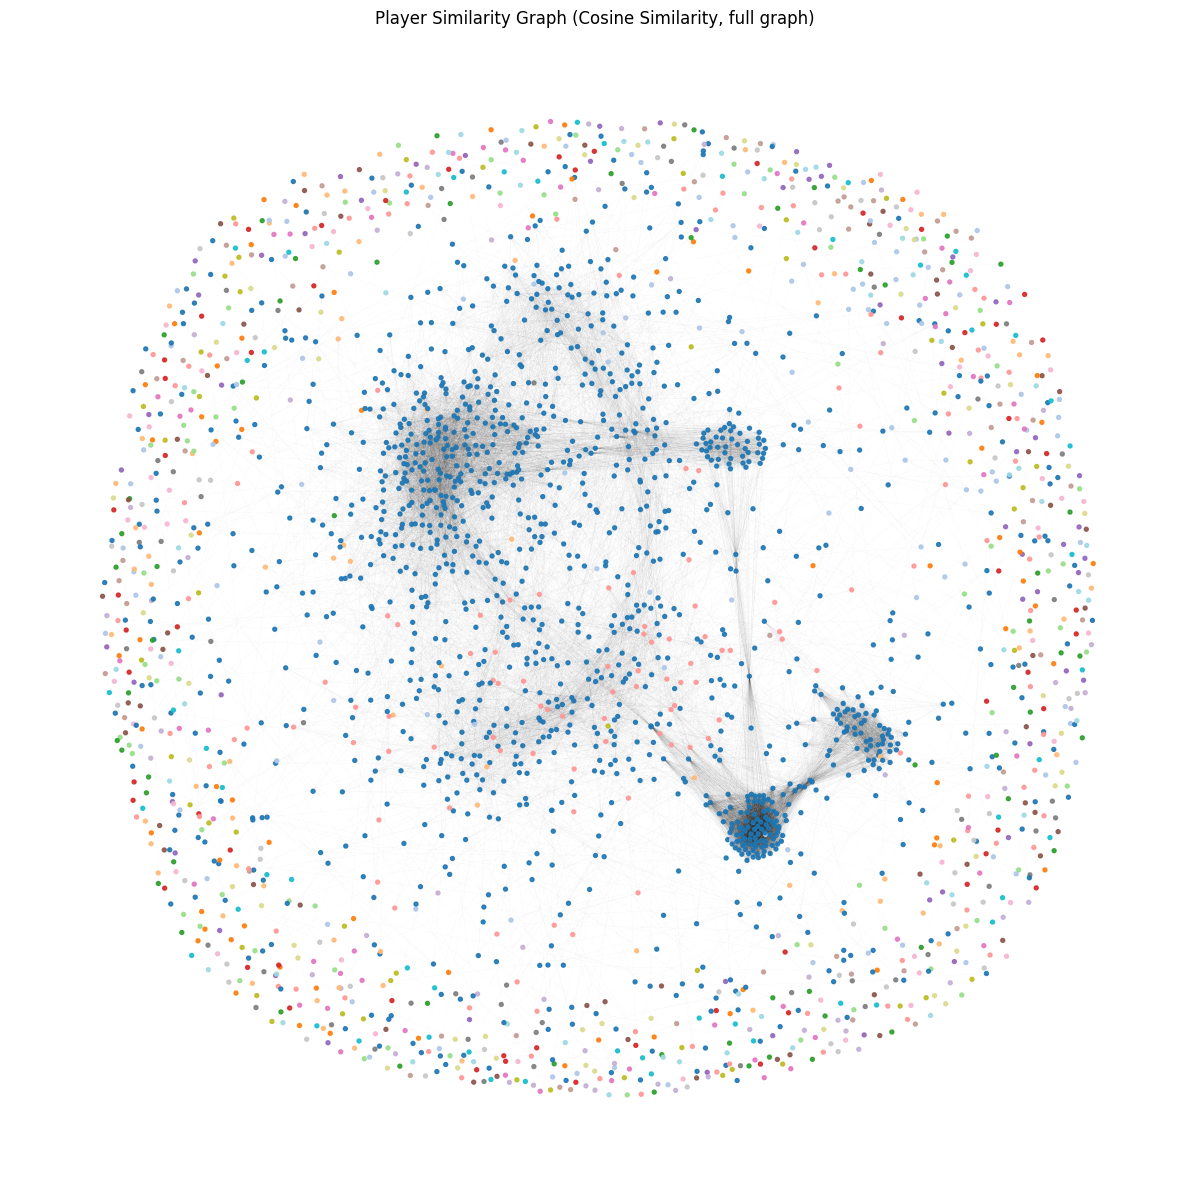

In [132]:
import matplotlib.pyplot as plt
import networkx as nx

H = G  # full similarity graph

pos = nx.spring_layout(
    H,
    k=0.15,
    iterations=30,
    weight="weight",
    seed=42
)

plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(
    H,
    pos,
    node_size=8,
    node_color=clusters,
    cmap="tab20",
    alpha=0.9
)
nx.draw_networkx_edges(
    H,
    pos,
    width=0.1,
    alpha=0.08
)

plt.title("Player Similarity Graph (Cosine Similarity, full graph)")
plt.axis("off")
plt.tight_layout()
plt.savefig("Full_graph.png")
plt.show()


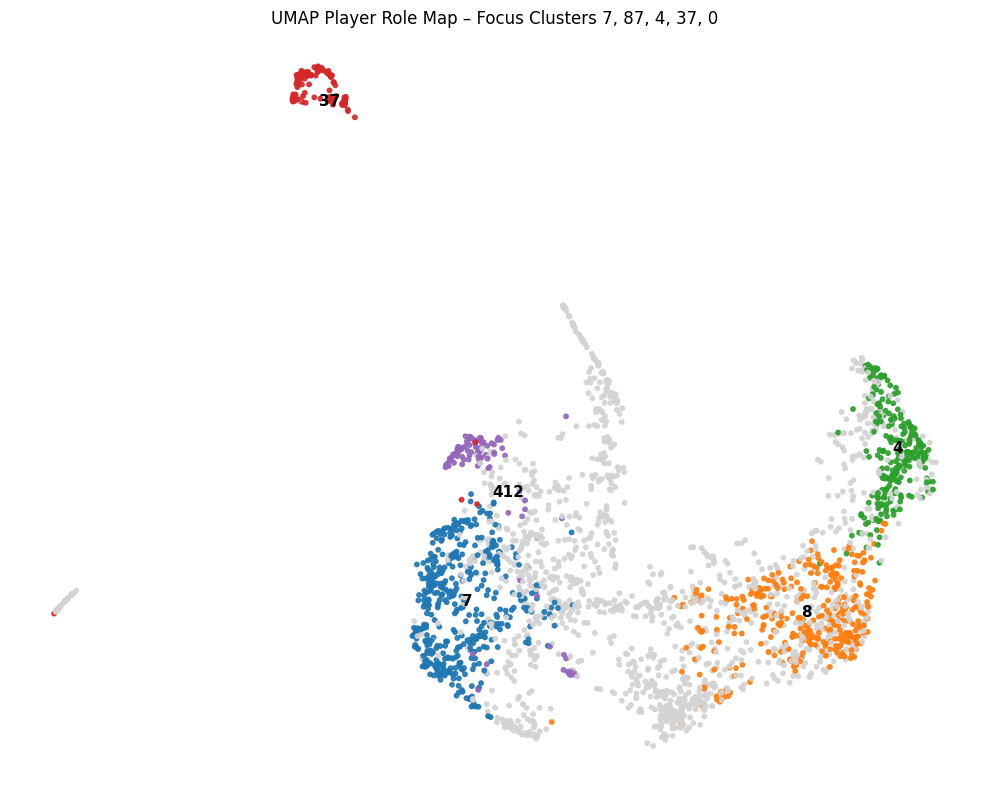

In [133]:
import numpy as np
import matplotlib.pyplot as plt

focus_clusters = [7,8,4,37,412]

cluster_series = player_features["cluster"]

# base: everything grey
colors = np.full(len(cluster_series), "lightgrey", dtype=object)

# nice distinct colors for your 5 clusters
color_map = {
    7:  "tab:blue",
    8: "tab:orange",
    4:  "tab:green",
    37: "tab:red",
    412:  "tab:purple",
}

for c, col in color_map.items():
    colors[cluster_series == c] = col

plt.figure(figsize=(10, 8))
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=colors,
    s=10,
    alpha=0.9
)

# label cluster centers
for c in focus_clusters:
    mask = (cluster_series == c)
    x_mean = embedding[mask, 0].mean()
    y_mean = embedding[mask, 1].mean()
    plt.text(x_mean, y_mean, str(c), fontsize=11, weight="bold")

plt.title("UMAP Player Role Map – Focus Clusters 7, 87, 4, 37, 0")
plt.axis("off")
plt.tight_layout()
plt.savefig("umap.png")
plt.show()


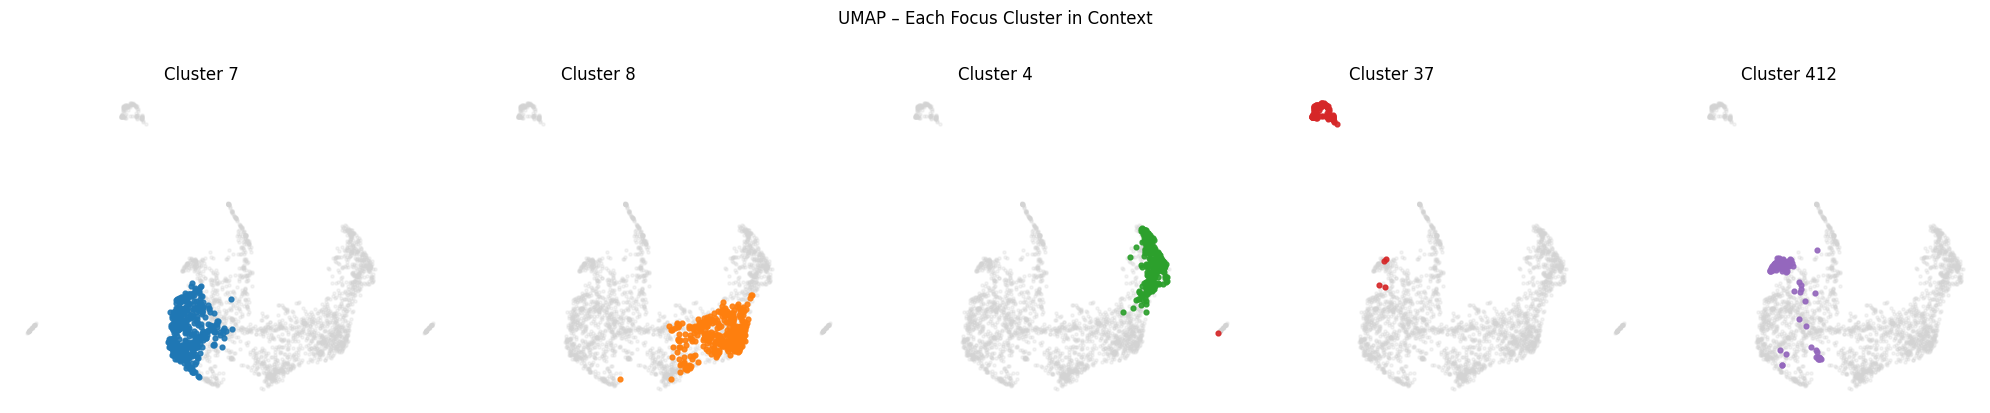

In [135]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4), sharex=True, sharey=True)

for ax, c in zip(axes, focus_clusters):
    mask = (cluster_series == c)

    # background: all players light grey
    ax.scatter(
        embedding[:, 0],
        embedding[:, 1],
        c="lightgrey",
        s=5,
        alpha=0.25
    )
    # this cluster highlighted
    ax.scatter(
        embedding[mask, 0],
        embedding[mask, 1],
        c=color_map[c],
        s=12,
        alpha=0.9
    )

    ax.set_title(f"Cluster {c}")
    ax.axis("off")

fig.suptitle("UMAP – Each Focus Cluster in Context", y=1.02)
plt.tight_layout
plt.tight_layout()
plt.savefig("umap2.png")
plt.show()


In [138]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import os

def plot_cluster_graph(cluster_id, max_nodes=200, save=False, save_dir="cluster_plots"):
    # Create directory if needed
    if save and not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # players in cluster
    names = player_features[player_features["cluster"] == cluster_id]["player"].tolist()

    if len(names) < 2:
        print(f"Cluster {cluster_id} has <2 players — skipping plot.")
        return

    # subsample if too big
    if len(names) > max_nodes:
        names = random.sample(names, max_nodes)

    Hc = G.subgraph(names).copy()

    # compute graph layout
    pos = nx.spring_layout(Hc, k=0.3, iterations=40, seed=42, weight="weight")

    plt.figure(figsize=(7, 7))

    nx.draw_networkx_nodes(
        Hc, pos,
        node_size=40,
        alpha=0.9,
        node_color=color_map.get(cluster_id, "tab:blue")
    )

    nx.draw_networkx_edges(
        Hc, pos,
        width=0.3,
        alpha=0.4
    )

    plt.title(f"Similarity Subgraph – Cluster {cluster_id}")
    plt.axis("off")

    # SAVE THE PLOT
    if save:
        filename = f"{save_dir}/cluster_{cluster_id}.png"
        plt.savefig(filename, dpi=300, bbox_inches="tight", pad_inches=0.1)
        print(f"Saved: {filename}")

    plt.show()

Saved: cluster_plots/cluster_7.png


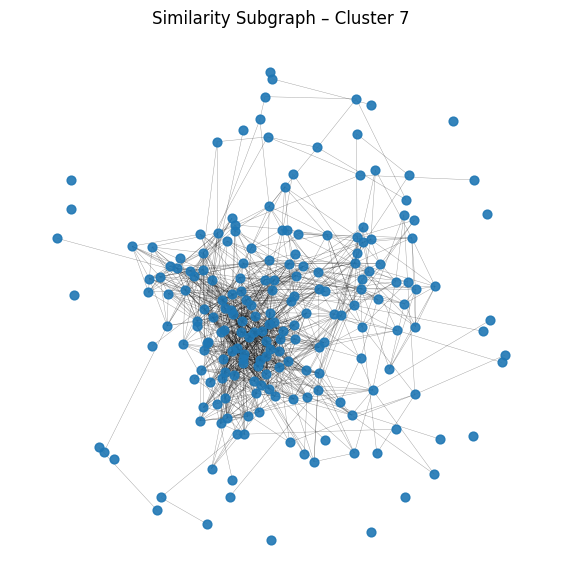

In [139]:
plot_cluster_graph(7, save=True)

Saved: cluster_plots/cluster_8.png


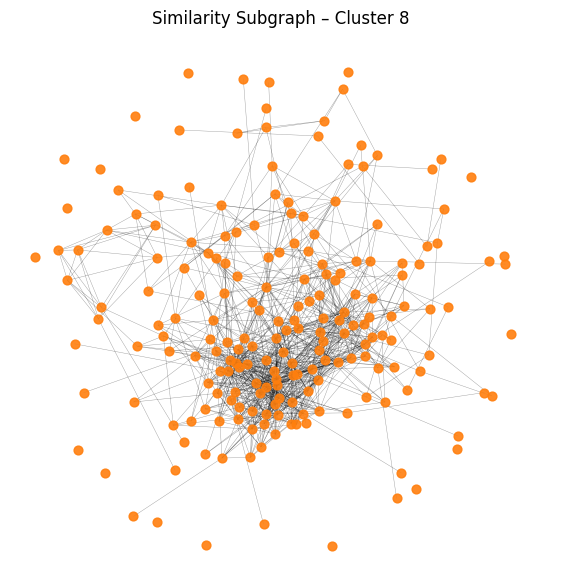

In [140]:
plot_cluster_graph(8, save=True)

Saved: cluster_plots/cluster_4.png


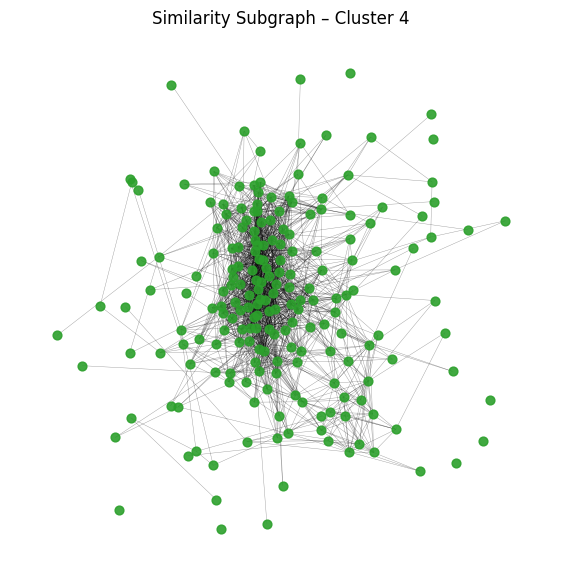

In [141]:
plot_cluster_graph(4, save=True)

Saved: cluster_plots/cluster_37.png


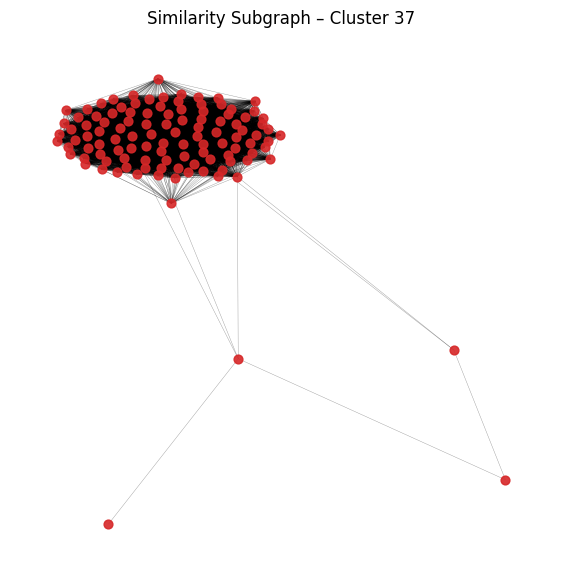

In [142]:
plot_cluster_graph(37, save=True)

Saved: cluster_plots/cluster_412.png


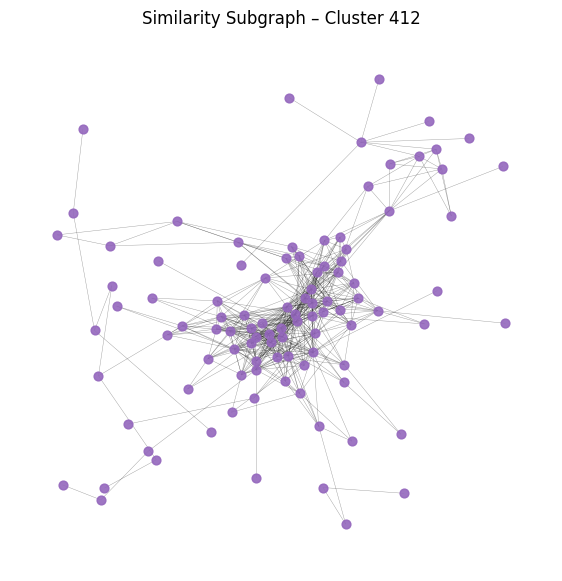

In [143]:
plot_cluster_graph(412, save=True)

In [144]:
import numpy as np

rep_players = {}

for c in focus_clusters:
    dfc = player_features[player_features["cluster"] == c]
    Xc = dfc[feature_cols].values
    centroid = Xc.mean(axis=0)
    dists = np.linalg.norm(Xc - centroid, axis=1)
    rep_idx = dists.argmin()
    rep_player = dfc.iloc[rep_idx]["player"]
    rep_players[c] = rep_player

rep_players

{7: 'Marin Pongračić',
 8: 'Willian',
 4: 'Raúl Jiménez',
 37: 'Unai Simón',
 412: 'Lorenzo Pirola'}

In [154]:
import networkx as nx
import matplotlib.pyplot as plt
import os

SAVE_PATH = r"C:\Users\vasil\Desktop\Msc\5th term\Computational Tools for Data Science"

def plot_ego_network(player_name, radius=1, save=False, save_dir=SAVE_PATH):
    
    # Create folder if needed
    if save and not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    # Build ego graph
    ego = nx.ego_graph(G, player_name, radius=radius)

    pos = nx.spring_layout(ego, k=0.3, iterations=40, seed=42, weight="weight")

    plt.figure(figsize=(7, 7))

    # Color: red = player, blue = neighbors
    node_colors = ["red" if n == player_name else "steelblue" for n in ego.nodes()]

    nx.draw_networkx_nodes(
        ego, pos,
        node_size=60,
        alpha=0.9,
        node_color=node_colors
    )

    nx.draw_networkx_edges(
        ego, pos,
        width=0.4,
        alpha=0.4
    )

    # Label only center + 10 neighbors
    labels = {player_name: player_name}
    for n in list(ego.nodes())[:10]:
        if n != player_name:
            labels[n] = n

    nx.draw_networkx_labels(ego, pos, labels, font_size=7)

    plt.title(f"Ego Network – {player_name}")
    plt.axis("off")

    # Save the image
    if save:
        filename = os.path.join(save_dir, f"ego_{player_name.replace(' ', '_')}.png")
        plt.savefig(filename, dpi=300, bbox_inches="tight", pad_inches=0.1)
        print(f"Saved to: {filename}")

    plt.show()

Cluster 7 representative: Marin Pongračić
Saved to: C:\Users\vasil\Desktop\Msc\5th term\Computational Tools for Data Science\ego_Marin_Pongračić.png


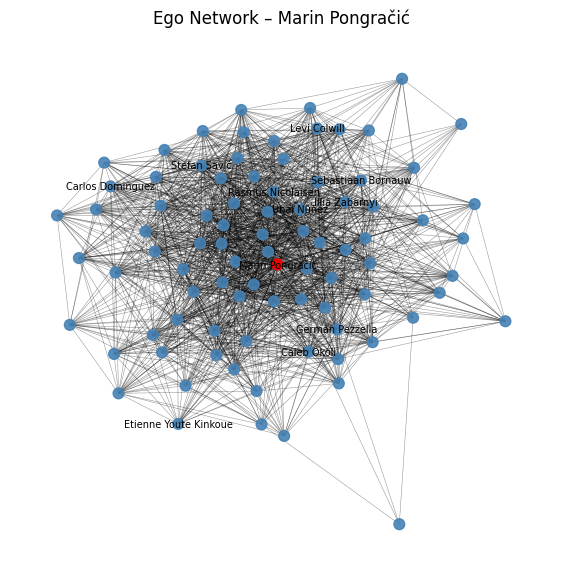

Cluster 8 representative: Willian
Saved to: C:\Users\vasil\Desktop\Msc\5th term\Computational Tools for Data Science\ego_Willian.png


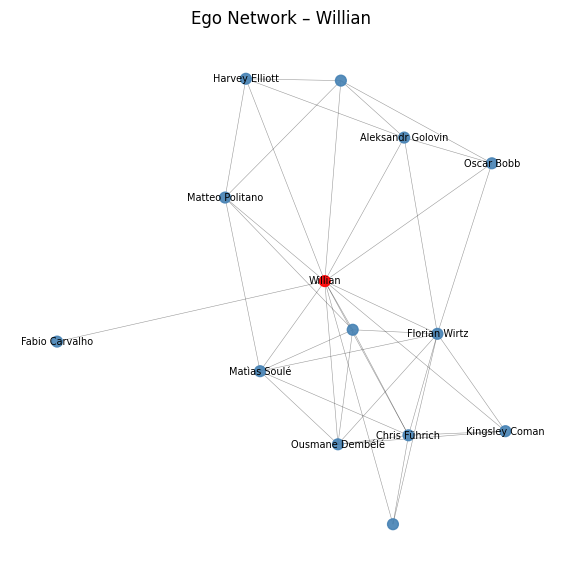

Cluster 4 representative: Raúl Jiménez
Saved to: C:\Users\vasil\Desktop\Msc\5th term\Computational Tools for Data Science\ego_Raúl_Jiménez.png


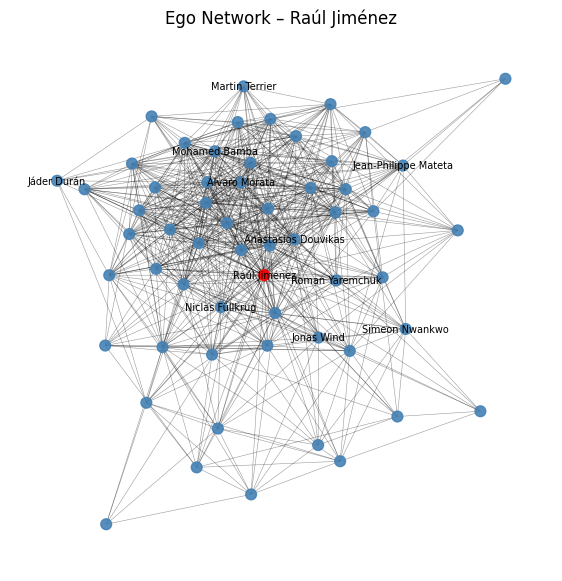

Cluster 37 representative: Unai Simón
Saved to: C:\Users\vasil\Desktop\Msc\5th term\Computational Tools for Data Science\ego_Unai_Simón.png


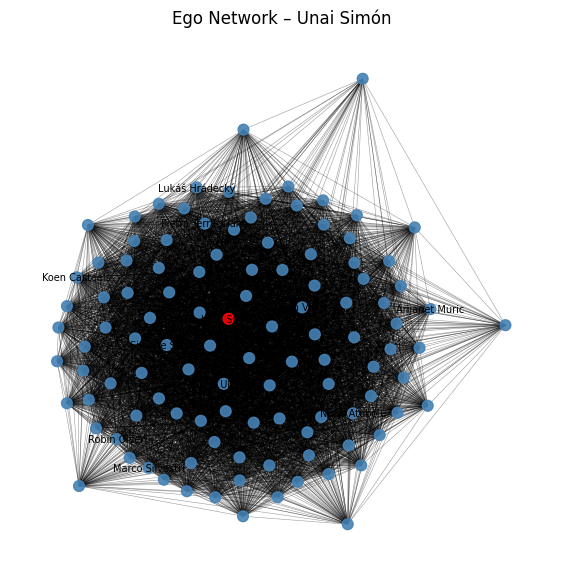

Cluster 412 representative: Lorenzo Pirola
Saved to: C:\Users\vasil\Desktop\Msc\5th term\Computational Tools for Data Science\ego_Lorenzo_Pirola.png


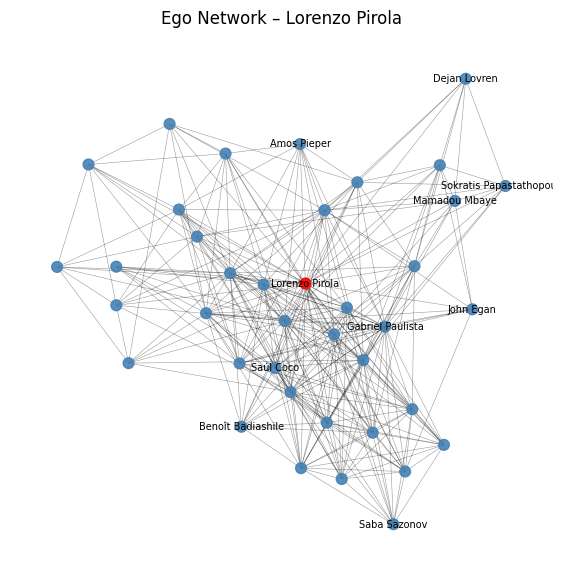

In [156]:
for c, p in rep_players.items():
    print(f"Cluster {c} representative: {p}")
    plot_ego_network(p, radius=1, save=True)


In [157]:
from sklearn.metrics.pairwise import cosine_similarity

centroids = []
for c in focus_clusters:
    dfc = player_features[player_features["cluster"] == c]
    centroids.append(dfc[feature_cols].mean().values)

centroids = np.vstack(centroids)

# cosine similarity between cluster centroids
C_sim = cosine_similarity(centroids)  # 5x5 matrix
C_sim

array([[1.        , 0.89620756, 0.88386491, 0.66409752, 0.82581867],
       [0.89620756, 1.        , 0.97266219, 0.4735057 , 0.71931104],
       [0.88386491, 0.97266219, 1.        , 0.5423078 , 0.76272532],
       [0.66409752, 0.4735057 , 0.5423078 , 1.        , 0.86439602],
       [0.82581867, 0.71931104, 0.76272532, 0.86439602, 1.        ]])

In [158]:
GC = nx.Graph()

# add nodes with labels
for c in focus_clusters:
    GC.add_node(c)

# add weighted edges between clusters (skip self-loops)
for i, ci in enumerate(focus_clusters):
    for j, cj in enumerate(focus_clusters):
        if j <= i:
            continue
        w = C_sim[i, j]
        GC.add_edge(ci, cj, weight=w)


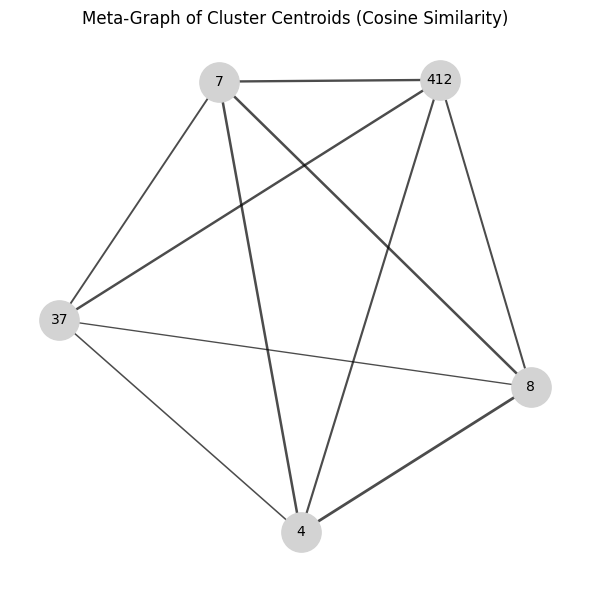

In [160]:
plt.figure(figsize=(6, 6))

pos = nx.spring_layout(GC, seed=42, weight="weight")

# edge widths proportional to similarity
weights = [GC[u][v]["weight"] for u, v in GC.edges()]
max_w = max(weights)
edge_widths = [2.0 * (w / max_w) for w in weights]

nx.draw_networkx_nodes(GC, pos, node_size=800, node_color="lightgrey")
nx.draw_networkx_edges(GC, pos, width=edge_widths, alpha=0.7)

# label nodes with cluster id (or persona name if you want)
labels = {c: str(c) for c in focus_clusters}
nx.draw_networkx_labels(GC, pos, labels, font_size=10)

plt.title("Meta-Graph of Cluster Centroids (Cosine Similarity)")
plt.axis("off")
plt.tight_layout()
plt.savefig("meta_graph.png")
plt.show()
